## Example of Van Der Pol oscillator (DeepXDE).
Use physics-informed neural network (PINN) to solve VDP oscillator.<br>
The specific equation is as follows:

\begin{equation}
 \frac {d^2u} {dt^2} + \omega_0^2 y - \epsilon \omega_0 (1 - u^2)\frac {du} {dt}  = 0, \\
 \end{equation}

  In this notebook a value $\epsilon = 1$ is taken with $\omega_0 = 15$, and the initial value is $u(t = 0) = 1$ together with $du/dt (t = 0) = 0$. 
  
  Used to make Figures X to X in paper.

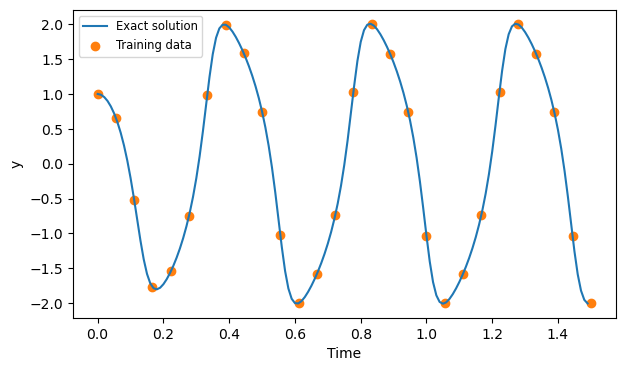

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks
import seaborn as sns

palette = sns.color_palette("muted")

def oscillator_model(t):
    def vdp(y, t, k1=15, k2=1):
        dxdt = [y[1] , k1*k2*(1-(y[0]**2))*y[1] - k1*k1*y[0]]
        return dxdt
    
    y0 = [1, 0]
    return odeint(vdp, y0, t)


def insert_points(t_data, num_inserts=3):
    new_t_data = []
    for i in range(len(t_data) - 1):
        new_t_data.append(t_data[i][0])
        inserts = np.linspace(t_data[i], t_data[i + 1], num_inserts + 2)[1:-1]
        new_t_data.extend(inserts.ravel())
    new_t_data.append(t_data[-1][0])
    return np.around(np.array(new_t_data), decimals=2)[:, None]


t = np.arange(0, 1.5, 0.01)[:, None]
y = oscillator_model(np.ravel(t))

peaks, _ = find_peaks(y[:, 0])
troughs, _ = find_peaks(-y[:, 0])

y = y[:, 0][:, None]

# t_data = np.concatenate((np.linspace(0.0, 1.5, 32)[:, None], t[peaks], t[troughs]), axis=0)
t_data = np.linspace(0.0, 1.5, 28)[:, None]
# t_data = insert_points(t_data)
# t_data = np.sort(t_data, axis=0)

y_data = np.interp(t_data.ravel(), t.ravel(), y.ravel())[:, None]

mean = 0            # 噪声均值
stddev = 0.05       # 噪声标准差
noise = np.random.normal(mean, stddev, y_data.shape)
y_data_noise = y_data + noise

plt.figure(figsize=(7, 4))
plt.plot(t, y, label="Exact solution")
plt.scatter(t_data, y_data, color="tab:orange", label="Training data")
# plt.scatter(t_data, y_data_noise.ravel(), marker='x', s=40, color=palette[4], label="Noise data")
# plt.scatter(t[peaks], y[peaks], color='r', label='Peaks')
# plt.scatter(t[troughs], y[troughs], color='g', label='Troughs')
plt.xlabel("Time")
plt.ylabel("y")
plt.legend(loc='upper left', fontsize='small')
plt.show()

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import time

def ode(t, y, k1=15, k2=1):
    dy_tt = dde.grad.hessian(y, t)
    dy_t = dde.grad.jacobian(y, t)
    return dy_tt - k1 * k2 * (1 - y ** 2) * dy_t + k1 * k1 * y


geom = dde.geometry.TimeDomain(0.0, 1.5)

# y (t = 0) = 1
ic1 = dde.icbc.IC(geom, lambda x : 1, lambda _, on_initial: on_initial)


def boundary_l(t, on_boundary):
    return on_boundary and dde.utils.isclose(t[0], 0)


def error_derivative(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None)


ic2 = dde.icbc.OperatorBC(geom, error_derivative, boundary_l)

t_y_data = dde.PointSetBC(t_data, y_data)
t_y_data_noise = dde.PointSetBC(t_data, y_data_noise)

data = dde.data.TimePDE(geom, ode, [ic1, ic2, t_y_data, ], train_distribution = "uniform", num_domain=15, num_boundary=1,
)

net = dde.maps.FNN([1] + [32] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=3e-4)

start_time = time.time()

model.train(epochs=24000)

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

y_pred = model.predict(t)


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...
'build' took 0.057054 s



c:\Users\Administrator\.conda\envs\PINN-GPU\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.306535 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.00e+00, 3.13e-03, 1.90e+00]    [1.00e+00, 3.13e-03, 1.90e+00]    []  
1000      [3.15e-04, 1.10e-04, 1.78e+00]    [3.15e-04, 1.10e-04, 1.78e+00]    []  
2000      [3.51e-05, 7.24e-07, 1.73e+00]    [3.51e-05, 7.24e-07, 1.73e+00]    []  
3000      [5.95e-05, 7.38e-07, 1.69e+00]    [5.95e-05, 7.38e-07, 1.69e+00]    []  
4000      [4.75e-05, 2.84e-07, 1.60e+00]    [4.75e-05, 2.84e-07, 1.60e+00]    []  
5000      [6.69e-07, 2.65e-10, 1.26e+00]    [6.69e-07, 2.65e-10, 1.26e+00]    []  
6000      [9.11e-06, 1.50e-08, 9.98e-01]    [9.11e-06, 1.50e-08, 9.98e-01]    []  
7000      [1.44e-06, 1.78e-03, 7.45e-01]    [1.44e-06, 1.78e-03, 7.45e-01]    []  
8000      [1.87e-05, 3.13e-05, 3.31e-01]    [1.87e-05, 3.13e-05, 3.31e-01]    []  
9000      [1.21e-07, 4.51e-08, 1.65e-02]    [1.21e-07, 4.51e-08, 1.65e-02]    []  
10000     [1.26e-07, 6.26e-07, 8.7

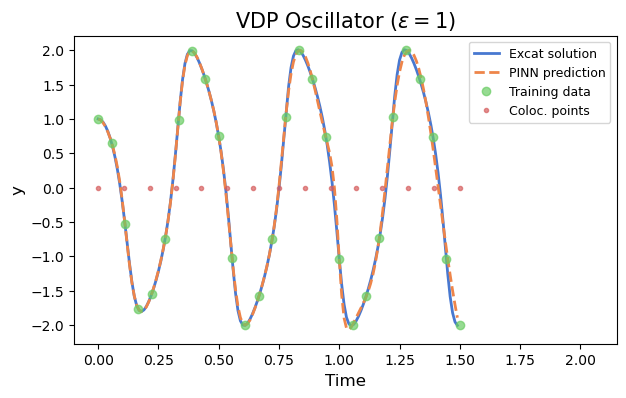

In [3]:
num_domain = np.linspace(0, 1.5, 15)

plt.figure(figsize=(7, 4))
plt.plot(t, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(t, y_pred, '--', color=palette[1], linewidth=2, label='PINN prediction')
plt.plot(t_data, y_data, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.plot(num_domain, np.zeros_like(num_domain), '.', color=palette[3], linewidth=2, alpha=0.7, label='Coloc. points')
# plt.scatter(t_data, y_data_noise.ravel(), marker='x', s=40, color=palette[4], label="Noise data")
plt.title(r'VDP Oscillator ($\epsilon=1$)', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.xlim([-0.1, 2.15])
plt.show()